For Question #2, filter to CMS users (cmslocal, cmspilot), examine relationship betw early (< 60 min) termination jobs, production & nogpfs partitions, and specific nodes.  Look for commonly failed nodes

Actions: 1) pull in code to convert time to seconds 2) run query for cms users, used time less than 3600 seconds and 1800 seconds, partition = production, nogpfs. 3) analyze exit codes: left = user errors, right = node errors. 4) run query for cms user, 30 mins, plus State = Failed.  4) analyze for commonly occurring failed nodes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
%matplotlib inline
from io import StringIO
import re

In [2]:
for_pd = StringIO()
with open('../data/accre-jobs-2020.csv') as accre:
    for line in accre:
        new_line = re.sub(r',', '|', line.rstrip(), count=12)
        print (new_line, file=for_pd)

for_pd.seek(0)

accre = pd.read_csv(for_pd, sep='|')
print (accre)

               JOBID        ACCOUNT       USER    REQMEM    USEDMEM  \
0           15925210        treviso   arabella  122880Mn  65973.49M   
1           15861126        treviso   arabella  122880Mn  67181.12M   
2           15861125        treviso   arabella  122880Mn  69111.86M   
3           16251645        treviso   arabella  122880Mn  65317.33M   
4           16251646        treviso   arabella  122880Mn  65876.11M   
...              ...            ...        ...       ...        ...   
3816285   24173815_8     portabella     vennie   32768Mn  30042.68M   
3816286   24173815_9     portabella     vennie   32768Mn  31067.75M   
3816287  24173815_10     portabella     vennie   32768Mn  21207.96M   
3816288     24173817  boysenberries  hortensia  100000Mn          0   
3816289     24173866    horseradish     ariane   20480Mn          0   

             REQTIME     USEDTIME  NODES  CPUS   PARTITION EXITCODE  \
0        13-18:00:00  13-18:00:28      1    24  production      0:0   
1    

In [3]:
accre.head()

,JOBID,ACCOUNT,USER,REQMEM,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,PARTITION,EXITCODE,STATE,NODELIST
0,15925210,treviso,arabella,122880Mn,65973.49M,13-18:00:00,13-18:00:28,1,24,production,0:0,COMPLETED,cn1531
1,15861126,treviso,arabella,122880Mn,67181.12M,13-18:00:00,12-14:50:56,1,24,production,0:0,COMPLETED,cn1441
2,15861125,treviso,arabella,122880Mn,69111.86M,13-18:00:00,13-18:00:20,1,24,production,0:0,COMPLETED,cn1464
3,16251645,treviso,arabella,122880Mn,65317.33M,13-18:00:00,12-03:50:32,1,24,production,0:0,COMPLETED,cn1473
4,16251646,treviso,arabella,122880Mn,65876.11M,13-18:00:00,13-18:00:03,1,24,production,0:0,COMPLETED,cn1440


In [4]:
accre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3816290 entries, 0 to 3816289
Data columns (total 13 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   JOBID      object
 1   ACCOUNT    object
 2   USER       object
 3   REQMEM     object
 4   USEDMEM    object
 5   REQTIME    object
 6   USEDTIME   object
 7   NODES      int64 
 8   CPUS       int64 
 9   PARTITION  object
 10  EXITCODE   object
 11  STATE      object
 12  NODELIST   object
dtypes: int64(2), object(11)
memory usage: 378.5+ MB


In [5]:
accre.groupby('STATE').size()

STATE
CANCELLED                 6107
CANCELLED by 0               5
CANCELLED by 124006          2
CANCELLED by 199066          2
CANCELLED by 199766          4
CANCELLED by 200557          6
CANCELLED by 337422          1
CANCELLED by 397600          7
CANCELLED by 454080          4
CANCELLED by 483348          3
CANCELLED by 486541          4
CANCELLED by 503585          1
CANCELLED by 505355         63
CANCELLED by 515423          2
CANCELLED by 546080          2
CANCELLED by 649319          3
CANCELLED by 649321          1
CANCELLED by 651701          1
CANCELLED by 666860          2
CANCELLED by 686562        681
CANCELLED by 693461          2
CANCELLED by 763605          1
CANCELLED by 781109          1
CANCELLED by 782535          1
CANCELLED by 782611         13
CANCELLED by 785271          1
CANCELLED by 791651          2
CANCELLED by 855431         17
CANCELLED by 895426          2
CANCELLED by 90423           2
CANCELLED by 9201            3
CANCELLED by 9202            3
CA

In [6]:
# bring in code to convert time to seconds 
# Create a function to split the hh:mm:ss string and calculate seconds from it
def to_sec(x):
    h,m,s = map(int,x.split(':'))
    return (h*60+m)*60+s

In [7]:
accre['REQTIME_DAY_SEC'] = accre['REQTIME'].str.extract('(\d+)-')
accre['REQTIME_DAY_SEC'] = pd.to_numeric(accre['REQTIME_DAY_SEC'])
accre['REQTIME_DAY_SEC'] = accre['REQTIME_DAY_SEC'].fillna(0)
accre['REQTIME_DAY_SEC'] = accre['REQTIME_DAY_SEC']*24*60*60
# Extract the hh:mm:ss from REQTIME, put in a new column, and then apply the to_sec function 
accre['REQTIME_T'] = accre['REQTIME'].str.extract('(..:..:..)$')
# REQTIME_SEC includes total seconds from REQTIME
accre['REQTIME_SEC'] = accre['REQTIME_T'].apply(to_sec) + accre['REQTIME_DAY_SEC']
# Do the same for USEDTIME
accre['USEDTIME_DAY_SEC'] = accre['USEDTIME'].str.extract('(\d+)-')
accre['USEDTIME_DAY_SEC'] = pd.to_numeric(accre['USEDTIME_DAY_SEC'])
accre['USEDTIME_DAY_SEC'] = accre['USEDTIME_DAY_SEC'].fillna(0)
accre['USEDTIME_DAY_SEC'] = accre['USEDTIME_DAY_SEC']*24*60*60
# Do the same for USEDTIME
accre['USEDTIME_T'] = accre['USEDTIME'].str.extract('(..:..:..)$')
# USEDTIME_SEC includes total second from USEDTIME
accre['USEDTIME_SEC'] = accre['USEDTIME_T'].apply(to_sec) + accre['USEDTIME_DAY_SEC']
# Check to make sure the data types look okay
accre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3816290 entries, 0 to 3816289
Data columns (total 19 columns):
 #   Column            Dtype  
---  ------            -----  
 0   JOBID             object 
 1   ACCOUNT           object 
 2   USER              object 
 3   REQMEM            object 
 4   USEDMEM           object 
 5   REQTIME           object 
 6   USEDTIME          object 
 7   NODES             int64  
 8   CPUS              int64  
 9   PARTITION         object 
 10  EXITCODE          object 
 11  STATE             object 
 12  NODELIST          object 
 13  REQTIME_DAY_SEC   float64
 14  REQTIME_T         object 
 15  REQTIME_SEC       float64
 16  USEDTIME_DAY_SEC  float64
 17  USEDTIME_T        object 
 18  USEDTIME_SEC      float64
dtypes: float64(4), int64(2), object(13)
memory usage: 553.2+ MB


In [8]:
#drop unnecessary columns
accre_cms = accre.drop(['REQMEM', 'USEDMEM', 'REQTIME', 'USEDTIME', 'REQTIME_DAY_SEC', 'REQTIME_T', 'USEDTIME_DAY_SEC', 'USEDTIME_T'], axis = 1)

In [9]:
accre_cms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3816290 entries, 0 to 3816289
Data columns (total 11 columns):
 #   Column        Dtype  
---  ------        -----  
 0   JOBID         object 
 1   ACCOUNT       object 
 2   USER          object 
 3   NODES         int64  
 4   CPUS          int64  
 5   PARTITION     object 
 6   EXITCODE      object 
 7   STATE         object 
 8   NODELIST      object 
 9   REQTIME_SEC   float64
 10  USEDTIME_SEC  float64
dtypes: float64(2), int64(2), object(7)
memory usage: 320.3+ MB


First, filter the users to cmspilot and cmslocal

In [10]:
#create dataframe narrowed to specified cms users
accre_cms_user = accre_cms.loc[accre_cms['USER'].isin(['cmslocal', 'cmspilot'])]
accre_cms_user

,JOBID,ACCOUNT,USER,NODES,CPUS,PARTITION,EXITCODE,STATE,NODELIST,REQTIME_SEC,USEDTIME_SEC
2125,17032244,cms,cmspilot,1,4,production,0:0,COMPLETED,cn1205,172800.0,171106.0
2126,17032568,cms,cmspilot,1,4,production,0:0,COMPLETED,cn1492,172800.0,171193.0
2127,17032569,cms,cmspilot,1,4,production,0:0,COMPLETED,cn1497,172800.0,171396.0
2128,17032916,cms,cmspilot,1,8,nogpfs,0:0,COMPLETED,ng1037,172800.0,170875.0
2129,17032920,cms,cmspilot,1,8,nogpfs,0:0,COMPLETED,ng691,172800.0,170164.0
...,...,...,...,...,...,...,...,...,...,...,...
3815978,24173154,cms,cmspilot,1,4,production,0:0,RUNNING,cn461,172800.0,401.0
3815979,24173155,cms,cmspilot,1,4,production,0:0,RUNNING,cn1516,172800.0,244.0
3815980,24173156,cms,cmspilot,1,4,production,0:0,RUNNING,cn1524,172800.0,244.0
3815981,24173158,cms,cmspilot,1,4,production,0:0,RUNNING,cn1532,172800.0,244.0


In [11]:
accre_cms_user.USER.unique()

array(['cmspilot', 'cmslocal'], dtype=object)

In [12]:
accre_cms_user.PARTITION.unique()

array(['production', 'nogpfs', 'pascal'], dtype=object)

In [13]:
accre_cms_user.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 836628 entries, 2125 to 3816000
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   JOBID         836628 non-null  object 
 1   ACCOUNT       836628 non-null  object 
 2   USER          836628 non-null  object 
 3   NODES         836628 non-null  int64  
 4   CPUS          836628 non-null  int64  
 5   PARTITION     836628 non-null  object 
 6   EXITCODE      836628 non-null  object 
 7   STATE         836628 non-null  object 
 8   NODELIST      836628 non-null  object 
 9   REQTIME_SEC   836628 non-null  float64
 10  USEDTIME_SEC  836628 non-null  float64
dtypes: float64(2), int64(2), object(7)
memory usage: 76.6+ MB


In [14]:
accre_cms_user.ACCOUNT.unique()

array(['cms', 'cms_lowprio', 'cms_gpu_acc'], dtype=object)

Note that although filtered to cmslocal and cmspilot, there are still 3 Accounts 

Now filter the partitions to production and nogpfs

In [15]:
# narrow the dataframe to the specified cms users, and production & nogpfs partitions
accre_cms_user_part = accre_cms_user.loc[accre_cms_user['PARTITION'].isin(['production', 'nogpfs'])]
accre_cms_user_part

,JOBID,ACCOUNT,USER,NODES,CPUS,PARTITION,EXITCODE,STATE,NODELIST,REQTIME_SEC,USEDTIME_SEC
2125,17032244,cms,cmspilot,1,4,production,0:0,COMPLETED,cn1205,172800.0,171106.0
2126,17032568,cms,cmspilot,1,4,production,0:0,COMPLETED,cn1492,172800.0,171193.0
2127,17032569,cms,cmspilot,1,4,production,0:0,COMPLETED,cn1497,172800.0,171396.0
2128,17032916,cms,cmspilot,1,8,nogpfs,0:0,COMPLETED,ng1037,172800.0,170875.0
2129,17032920,cms,cmspilot,1,8,nogpfs,0:0,COMPLETED,ng691,172800.0,170164.0
...,...,...,...,...,...,...,...,...,...,...,...
3815978,24173154,cms,cmspilot,1,4,production,0:0,RUNNING,cn461,172800.0,401.0
3815979,24173155,cms,cmspilot,1,4,production,0:0,RUNNING,cn1516,172800.0,244.0
3815980,24173156,cms,cmspilot,1,4,production,0:0,RUNNING,cn1524,172800.0,244.0
3815981,24173158,cms,cmspilot,1,4,production,0:0,RUNNING,cn1532,172800.0,244.0


In [16]:
accre_cms_user_part.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 835473 entries, 2125 to 3816000
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   JOBID         835473 non-null  object 
 1   ACCOUNT       835473 non-null  object 
 2   USER          835473 non-null  object 
 3   NODES         835473 non-null  int64  
 4   CPUS          835473 non-null  int64  
 5   PARTITION     835473 non-null  object 
 6   EXITCODE      835473 non-null  object 
 7   STATE         835473 non-null  object 
 8   NODELIST      835473 non-null  object 
 9   REQTIME_SEC   835473 non-null  float64
 10  USEDTIME_SEC  835473 non-null  float64
dtypes: float64(2), int64(2), object(7)
memory usage: 76.5+ MB


In [17]:
accre_cms_user_part.PARTITION.unique()

array(['production', 'nogpfs'], dtype=object)

In [18]:
accre_cms_user_part.ACCOUNT.unique()

array(['cms', 'cms_lowprio'], dtype=object)

Note there are now 2 Accounts associated with cmslocal and cmspilot

So we now have a database with cmslocal/cmspilot as the Users and production/nogpfs as the Partitions. Next, filter to jobs less than 60 minutes, and a separate df with 30 minutes.  (Note: I originally tried to first filter on original USEDTIME less than 1:00 but got error '<' not supported betw 'list' and 'str'

In [19]:
# df with jobs less than 60 minutes.  I used 60 minutes, 2 seconds in case the last digit is not included and 
#there's a delay in cancel execution.  
accre_cms_user_part_1hr = accre_cms_user_part[accre_cms_user_part['USEDTIME_SEC'].between(0,3602)]
accre_cms_user_part_1hr

,JOBID,ACCOUNT,USER,NODES,CPUS,PARTITION,EXITCODE,STATE,NODELIST,REQTIME_SEC,USEDTIME_SEC
8061,17093431,cms,cmslocal,1,8,nogpfs,0:0,COMPLETED,ng1017,172800.0,1327.0
8062,17093435,cms,cmslocal,1,8,nogpfs,0:0,COMPLETED,ng1027,172800.0,1311.0
8064,17093439,cms,cmslocal,1,8,nogpfs,0:0,COMPLETED,ng1020,172800.0,1224.0
8065,17093440,cms,cmslocal,1,8,nogpfs,0:0,COMPLETED,ng1036,172800.0,1224.0
8066,17093441,cms,cmslocal,1,8,nogpfs,0:0,COMPLETED,ng1003,172800.0,1231.0
...,...,...,...,...,...,...,...,...,...,...,...
3815978,24173154,cms,cmspilot,1,4,production,0:0,RUNNING,cn461,172800.0,401.0
3815979,24173155,cms,cmspilot,1,4,production,0:0,RUNNING,cn1516,172800.0,244.0
3815980,24173156,cms,cmspilot,1,4,production,0:0,RUNNING,cn1524,172800.0,244.0
3815981,24173158,cms,cmspilot,1,4,production,0:0,RUNNING,cn1532,172800.0,244.0


In [20]:
accre_cms_user_part_1hr.describe()

,NODES,CPUS,REQTIME_SEC,USEDTIME_SEC
count,509499.0,509499.000000,509499.000000,509499.000000
mean,1.0,6.622384,170990.814506,961.520470
std,0.0,6.154231,17464.355821,693.418003
min,1.0,0.000000,1800.000000,0.000000
25%,1.0,4.000000,172800.000000,148.000000
50%,1.0,4.000000,172800.000000,1207.000000
75%,1.0,8.000000,172800.000000,1239.000000
max,1.0,64.000000,172800.000000,3602.000000


In [21]:
#df with jobs less than 30 minutes.  I used 30 minutes, 2 seconds in case the last digit is not included and 
#there's a delay in cancel execution. 
accre_cms_user_part_30 = accre_cms_user_part[accre_cms_user_part['USEDTIME_SEC'].between(0,1802)]
accre_cms_user_part_30

,JOBID,ACCOUNT,USER,NODES,CPUS,PARTITION,EXITCODE,STATE,NODELIST,REQTIME_SEC,USEDTIME_SEC
8061,17093431,cms,cmslocal,1,8,nogpfs,0:0,COMPLETED,ng1017,172800.0,1327.0
8062,17093435,cms,cmslocal,1,8,nogpfs,0:0,COMPLETED,ng1027,172800.0,1311.0
8064,17093439,cms,cmslocal,1,8,nogpfs,0:0,COMPLETED,ng1020,172800.0,1224.0
8065,17093440,cms,cmslocal,1,8,nogpfs,0:0,COMPLETED,ng1036,172800.0,1224.0
8066,17093441,cms,cmslocal,1,8,nogpfs,0:0,COMPLETED,ng1003,172800.0,1231.0
...,...,...,...,...,...,...,...,...,...,...,...
3815978,24173154,cms,cmspilot,1,4,production,0:0,RUNNING,cn461,172800.0,401.0
3815979,24173155,cms,cmspilot,1,4,production,0:0,RUNNING,cn1516,172800.0,244.0
3815980,24173156,cms,cmspilot,1,4,production,0:0,RUNNING,cn1524,172800.0,244.0
3815981,24173158,cms,cmspilot,1,4,production,0:0,RUNNING,cn1532,172800.0,244.0


In [22]:
accre_cms_user_part_30.describe()

,NODES,CPUS,REQTIME_SEC,USEDTIME_SEC
count,474044.0,474044.000000,474044.000000,474044.000000
mean,1.0,6.823154,172034.455873,844.716611
std,0.0,6.231422,11370.900026,546.847968
min,1.0,0.000000,1800.000000,0.000000
25%,1.0,4.000000,172800.000000,110.000000
50%,1.0,8.000000,172800.000000,1205.000000
75%,1.0,8.000000,172800.000000,1230.000000
max,1.0,64.000000,172800.000000,1802.000000


474044 cms jobs, or 57%, are less than 30 minutes.  509,499 cms jobs, or 61%, are less than 1 hr.  Will focus on 30 minutes.  

In [23]:
accre_cms_user_part_30.sort_values('USEDTIME_SEC',ascending = 'false')
accre_cms_user_part_30

,JOBID,ACCOUNT,USER,NODES,CPUS,PARTITION,EXITCODE,STATE,NODELIST,REQTIME_SEC,USEDTIME_SEC
8061,17093431,cms,cmslocal,1,8,nogpfs,0:0,COMPLETED,ng1017,172800.0,1327.0
8062,17093435,cms,cmslocal,1,8,nogpfs,0:0,COMPLETED,ng1027,172800.0,1311.0
8064,17093439,cms,cmslocal,1,8,nogpfs,0:0,COMPLETED,ng1020,172800.0,1224.0
8065,17093440,cms,cmslocal,1,8,nogpfs,0:0,COMPLETED,ng1036,172800.0,1224.0
8066,17093441,cms,cmslocal,1,8,nogpfs,0:0,COMPLETED,ng1003,172800.0,1231.0
...,...,...,...,...,...,...,...,...,...,...,...
3815978,24173154,cms,cmspilot,1,4,production,0:0,RUNNING,cn461,172800.0,401.0
3815979,24173155,cms,cmspilot,1,4,production,0:0,RUNNING,cn1516,172800.0,244.0
3815980,24173156,cms,cmspilot,1,4,production,0:0,RUNNING,cn1524,172800.0,244.0
3815981,24173158,cms,cmspilot,1,4,production,0:0,RUNNING,cn1532,172800.0,244.0


In [24]:
accre_cms_user_part_30.groupby('STATE')['STATE'].count()

STATE
CANCELLED              1988
CANCELLED by 9201         3
CANCELLED by 9202         3
COMPLETED            471926
FAILED                   61
RUNNING                  63
Name: STATE, dtype: int64

Only 61 failed jobs for the cms dataset

In [25]:
accre_cms_user_part_30_fail = accre_cms_user_part_30[accre_cms_user_part_30['STATE'] == 'FAILED']
accre_cms_user_part_30_fail

,JOBID,ACCOUNT,USER,NODES,CPUS,PARTITION,EXITCODE,STATE,NODELIST,REQTIME_SEC,USEDTIME_SEC
8629,17094238,cms,cmspilot,1,0,nogpfs,1:0,FAILED,cn1554,172800.0,71.0
8632,17094335,cms,cmspilot,1,0,nogpfs,1:0,FAILED,cn1544,172800.0,86.0
22234,17072678,cms,cmspilot,1,8,nogpfs,126:0,FAILED,ng909,172800.0,155.0
197972,17350102,cms,cmspilot,1,32,nogpfs,1:0,FAILED,cn1581,172800.0,92.0
197973,17350123,cms,cmslocal,1,32,nogpfs,1:0,FAILED,cn1563,172800.0,113.0
...,...,...,...,...,...,...,...,...,...,...,...
2194734,20958051,cms,cmslocal,1,4,production,127:0,FAILED,cn1536,172800.0,65.0
2505543,21577870,cms,cmspilot,1,4,production,127:0,FAILED,cn1523,172800.0,115.0
2505544,21577875,cms,cmspilot,1,4,production,127:0,FAILED,cn1523,172800.0,116.0
3259530,23146628,cms,cmspilot,1,8,nogpfs,127:0,FAILED,ng739,172800.0,67.0


In [26]:
accre_cms_user_part_30_fail.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61 entries, 8629 to 3447091
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   JOBID         61 non-null     object 
 1   ACCOUNT       61 non-null     object 
 2   USER          61 non-null     object 
 3   NODES         61 non-null     int64  
 4   CPUS          61 non-null     int64  
 5   PARTITION     61 non-null     object 
 6   EXITCODE      61 non-null     object 
 7   STATE         61 non-null     object 
 8   NODELIST      61 non-null     object 
 9   REQTIME_SEC   61 non-null     float64
 10  USEDTIME_SEC  61 non-null     float64
dtypes: float64(2), int64(2), object(7)
memory usage: 5.7+ KB


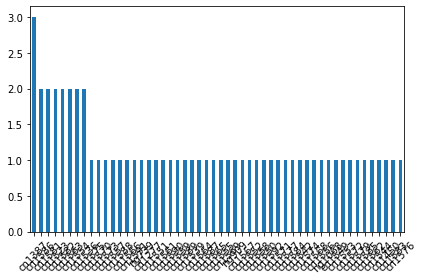

In [27]:
accre_cms_user_part_30_fail.NODELIST.value_counts().plot(kind = 'bar')
plt.xticks(rotation=45)
plt.tight_layout()

In [28]:
accre_cms_user_part_30_fail.NODELIST.describe()

count         61
unique        52
top       cn1387
freq           3
Name: NODELIST, dtype: object

There were only 61 failed jobs for cms jobs under 30 minutes. There were 52 unique Nodelists, with the most frequent cn1387. 

In [29]:
def find_most_common_values(df,column):
    return df[column].value_counts(ascending=False).iloc[0:50]

In [30]:
# most common failing nodelists for cms dataset
find_most_common_values(accre_cms_user_part_30_fail, 'NODELIST')

cn1387    3
cn1586    2
cn1581    2
cn1523    2
cn1582    2
cn1563    2
cn1554    2
cn1536    2
cn1575    1
cn1570    1
cn1573    1
cn1557    1
cn1588    1
cn1566    1
cn1591    1
ng739     1
cn1277    1
cn1551    1
cn1561    1
cn1590    1
cn1559    1
cn1589    1
cn1539    1
cn1564    1
cn1587    1
cn1565    1
cn1555    1
cn1569    1
ng909     1
cn1567    1
cn1552    1
cn1558    1
cn1550    1
cn1592    1
cn1571    1
cn1577    1
cn1584    1
cn1542    1
cn1574    1
cn1568    1
cn1556    1
ng1068    1
cn1549    1
cn1553    1
cn1572    1
cn1579    1
cn1585    1
cn1562    1
cn1544    1
cn1450    1
Name: NODELIST, dtype: int64

Additional review.  Although not part of question, now determine the number of cancelled jobs under 30 minutes

In [1]:
accre_cms_user_part_30_cxl = accre_cms_user_part_30[accre_cms_user_part_30['STATE'] == 'CANCELLED']
accre_cms_user_part_30_cxl

NameError: name 'accre_cms_user_part_30' is not defined

In [2]:
accre_cms_user_part_30_cxl.info()

NameError: name 'accre_cms_user_part_30_cxl' is not defined

In [33]:
# review cancelled jobs under 30 minutes' nodelist.  There are 626 unique nodelists
accre_cms_user_part_30_cxl.NODELIST.describe()

count       1988
unique       626
top       cn1314
freq          15
Name: NODELIST, dtype: object

In [34]:
accre_cms_user_part_30_cxl.EXITCODE.describe()

count     1988
unique       3
top        0:0
freq      1947
Name: EXITCODE, dtype: object

In [35]:
find_most_common_values(accre_cms_user_part_30_cxl, 'NODELIST')

cn1314    15
cn1391    15
ng518     15
cn394     13
cn1089    12
cn449     12
cn1121    11
cn1270    11
cn363     10
cn1124    10
cn1094    10
cn477     10
ng734     10
cn304     10
cn1398    10
cn408     10
cn1394     9
cn380      9
ng1112     9
cn1445     9
cn312      9
cn475      9
cn1095     9
cn1122     9
cn1218     8
cn1310     8
cn1474     8
cn405      8
cn1306     8
cn1435     8
cn399      8
cn429      8
cn306      8
cn495      7
cn1339     7
cn1372     7
cn1432     7
ng1033     7
cn1338     7
cn1440     7
cn1383     7
cn493      7
cn1090     7
cn1379     7
cn1337     7
cn1273     7
cn485      7
cn1096     7
cn1319     7
cn1376     7
Name: NODELIST, dtype: int64

In [36]:
accre_cms_user_part_30_cxl['STATE'].describe()

count          1988
unique            1
top       CANCELLED
freq           1988
Name: STATE, dtype: object

In [37]:
accre_cms_user_part_30.EXITCODE.unique()

array(['0:0', '1:0', '126:0', '0:9', '127:0'], dtype=object)

In [38]:
accre.STATE.describe()

count       3816290
unique           38
top       COMPLETED
freq        3804644
Name: STATE, dtype: object

In [39]:
accre_cms.PARTITION.describe()

count        3816290
unique            15
top       production
freq         3311788
Name: PARTITION, dtype: object

In [40]:
accre_cms.PARTITION.unique()

array(['production', 'cgw-dougherty1', 'cgw-capra1', 'cgw-cqs1', 'pascal',
       'turing', 'cgw-tbi01', 'nogpfs', 'maxwell', 'sam', 'debug',
       'devel', 'cgw-cqs3', 'cgw-rocksteady', 'cgw-vm-qa-flatearth1'],
      dtype=object)

In [41]:
# review failed nodes, first identify failed jobs
failed = accre[accre['STATE'] == 'FAILED']
failed

,JOBID,ACCOUNT,USER,REQMEM,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,PARTITION,EXITCODE,STATE,NODELIST,REQTIME_DAY_SEC,REQTIME_T,REQTIME_SEC,USEDTIME_DAY_SEC,USEDTIME_T,USEDTIME_SEC
8629,17094238,cms,cmspilot,186648Mn,1.78M,2-00:00:00,00:01:11,1,0,nogpfs,1:0,FAILED,cn1554,172800.0,00:00:00,172800.0,0.0,00:01:11,71.0
8632,17094335,cms,cmspilot,186648Mn,8.38M,2-00:00:00,00:01:26,1,0,nogpfs,1:0,FAILED,cn1544,172800.0,00:00:00,172800.0,0.0,00:01:26,86.0
22234,17072678,cms,cmspilot,21875Mn,11310.72M,2-00:00:00,00:02:35,1,8,nogpfs,126:0,FAILED,ng909,172800.0,00:00:00,172800.0,0.0,00:02:35,155.0
56716,17150413,blueberries,leva,4096Mn,1968.02M,10:00:00,02:15:54,1,1,pascal,1:0,FAILED,gpu0021,0.0,10:00:00,36000.0,0.0,02:15:54,8154.0
68661,17178412,cubanelle,robyn,1024Mc,73.32M,00:15:00,00:14:17,1,1,pascal,2:0,FAILED,gpu0021,0.0,00:15:00,900.0,0.0,00:14:17,857.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3813639,24168919,pinole,daryl,376832Mn,11.52M,00:30:00,00:01:28,1,1,turing,1:0,FAILED,gpu0048,0.0,00:30:00,1800.0,0.0,00:01:28,88.0
3814389,24170236,alkmene,abigail,8192Mn,5.81M,02:00:00,00:08:07,2,8,production,1:0,FAILED,"cn[1123,1128]",0.0,02:00:00,7200.0,0.0,00:08:07,487.0
3814493,24170522,alkmene,abigail,8192Mn,5.81M,02:00:00,00:08:42,2,8,production,1:0,FAILED,"cn[1207,1455]",0.0,02:00:00,7200.0,0.0,00:08:42,522.0
3814510,24170592,pinole,daryl,380280Mn,6.10M,00:30:00,00:02:25,1,1,turing,126:0,FAILED,gpu0045,0.0,00:30:00,1800.0,0.0,00:02:25,145.0


In [42]:
failed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1406 entries, 8629 to 3816160
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   JOBID             1406 non-null   object 
 1   ACCOUNT           1406 non-null   object 
 2   USER              1406 non-null   object 
 3   REQMEM            1406 non-null   object 
 4   USEDMEM           1406 non-null   object 
 5   REQTIME           1406 non-null   object 
 6   USEDTIME          1406 non-null   object 
 7   NODES             1406 non-null   int64  
 8   CPUS              1406 non-null   int64  
 9   PARTITION         1406 non-null   object 
 10  EXITCODE          1406 non-null   object 
 11  STATE             1406 non-null   object 
 12  NODELIST          1406 non-null   object 
 13  REQTIME_DAY_SEC   1406 non-null   float64
 14  REQTIME_T         1406 non-null   object 
 15  REQTIME_SEC       1406 non-null   float64
 16  USEDTIME_DAY_SEC  1406 non-null   fl

In [43]:
failed.NODELIST.unique()

array(['cn1554', 'cn1544', 'ng909', 'gpu0021', 'gpu0020', 'gpu0019',
       'gpu0024', 'gpu0025',
       'cn[336-338,340,347-348,374-380,386-396,401,403-405,407-411,487-500,911-913,1081]',
       'cn394', 'gpu0026', 'gpu0017', 'gpu0028', 'gpu0001', 'gpu0015',
       'gpu0030', 'cn[326,499]', 'gpu0002', 'cn371', 'cn1581', 'cn1563',
       'cn1582', 'cn1539',
       'cn[331-338,340,347-349,361-367,386-393,395-396,398-401,403-405,407-414,441-448,464-473,1273-1279,1340-1345]',
       'gpu0023', 'cn[1263,1275,1303,1309,1335-1336,1351,1372,1376,1424]',
       'cn[1263,1275,1287,1303,1309,1335-1336,1351,1372,1376]',
       'cn[1263,1275,1287,1303,1309,1335-1336,1351,1372-1373]',
       'cn[1263,1275,1287,1303,1309,1335-1336,1348,1372-1373]',
       'cn[1274-1277,1303-1321,1345-1354,1420-1427]', 'gpu0035', 'cn1101',
       'cn[1442,1444]', 'cn[1301,1382]', 'cn469', 'cn1446', 'cn1431',
       'cn1212', 'cn[1356,1379]', 'cn1273', 'cn[1332-1334]',
       'cn[1458,1464,1531-1533]', 'gpu0013', 'gpu

In [44]:
failed.NODELIST.value_counts()

gpu0019                                                                                                                                                                                      96
gpu0023                                                                                                                                                                                      60
gpu0014                                                                                                                                                                                      38
gpu0020                                                                                                                                                                                      36
gpu0013                                                                                                                                                                                      36
                                        

In [45]:
def find_most_common_values(df,column):
    return df[column].value_counts(ascending=False).iloc[0:30]

In [46]:
find_most_common_values(failed, 'NODELIST')

gpu0019           96
gpu0023           60
gpu0014           38
gpu0020           36
gpu0013           36
gpu0030           35
gpu0015           31
gpu0024           30
gpu0031           30
gpu0025           29
gpu0021           28
gpu0027           26
gpu0018           26
gpu0029           25
gpu0016           24
gpu0017           23
gpu0026           22
gpu0028           21
gpu0032           17
gpu0008           14
gpu[0030-0032]    14
gpu0034           13
gpu0033           11
cn1101            11
gpu0007           10
cn1231             9
gpu0005            9
cn1273             9
gpu0012            9
gpu0011            8
Name: NODELIST, dtype: int64